In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define tickers
tickers = {
    'Canada_Tech': 'XIT.TO',       # iShares S&P/TSX Capped Information Tech
    'Canada_Financials': 'XFN.TO', # iShares S&P/TSX Capped Financials
    'Canada_Energy': 'XEG.TO',     # iShares S&P/TSX Capped Energy
    'Global_Tech': 'XLK',          # SPDR Tech Select Sector (US proxy)
    'Global_Financials': 'XLF',
    'Global_Energy': 'XLE'
}


# Step 1: Function to check data cleanliness
def check_data_cleanliness(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period="max",auto_adjust=True)
    
    if hist.empty:
        print(f"[!] No data for {ticker}")
        return None

    # Check for missing values
    missing_vals = hist.isnull().sum()
    
    # Check for zero or negative prices
    invalid_prices = (hist[['Open', 'High', 'Low', 'Close']] <= 0).sum()
    
    # Check for missing dividend data
    dividends = stock.dividends
    missing_dividends = 0
    if dividends.empty:
        missing_dividends = 1
    
    print(f"--- {ticker} ---")
    print("Missing values:\n", missing_vals)
    print("Zero/negative prices:\n", invalid_prices)
    print("Dividend info available:", "No" if missing_dividends else "Yes")
    
    return hist

# Step 2: Function to clean data
def clean_yahoo_data(ticker):
    hist = check_data_cleanliness(ticker)
    if hist is None:
        return None
    
    # Forward/backward fill missing data
    hist.fillna(method='ffill', inplace=True)
    hist.fillna(method='bfill', inplace=True)
    
    # Initialize Adj Close with Close
    hist['Adj Close'] = hist['Close'].copy()
    
    # Adjust for dividends
    stock = yf.Ticker(ticker)
    dividends = stock.dividends
    for date, dividend in dividends.items():
        hist.loc[hist.index < date, 'Adj Close'] *= (1 + dividend / hist.loc[date, 'Close'])
    
    # Adjust for splits
    splits = stock.splits
    for date, split_ratio in splits.items():
        hist.loc[hist.index < date, 'Adj Close'] /= split_ratio
    
    # Remove zero or negative prices
    hist = hist[hist['Close'] > 0]
    
    return hist

# Run checks and cleaning
cleaned_data = {}
for name, ticker in tickers.items():
    print(f"\nChecking data for {name} ({ticker})")
    cleaned_data[name] = clean_yahoo_data(ticker)

# Combine adjusted close into a single DataFrame
combined_adj_close = pd.concat({k: v['Adj Close'] for k, v in cleaned_data.items()}, axis=1)
print("\nCombined Adjusted Close (last 5 rows):")
print(combined_adj_close.tail())



Checking data for Canada_Tech (XIT.TO)
--- XIT.TO ---
Missing values:
 Open             0
High             0
Low              0
Close            0
Volume           0
Dividends        0
Stock Splits     0
Capital Gains    0
dtype: int64
Zero/negative prices:
 Open     0
High     0
Low      0
Close    0
dtype: int64
Dividend info available: Yes

Checking data for Canada_Financials (XFN.TO)
--- XFN.TO ---
Missing values:
 Open             0
High             0
Low              0
Close            0
Volume           0
Dividends        0
Stock Splits     0
Capital Gains    0
dtype: int64
Zero/negative prices:
 Open     0
High     0
Low      0
Close    0
dtype: int64
Dividend info available: Yes

Checking data for Canada_Energy (XEG.TO)
--- XEG.TO ---
Missing values:
 Open             0
High             0
Low              0
Close            0
Volume           0
Dividends        0
Stock Splits     0
Capital Gains    0
dtype: int64
Zero/negative prices:
 Open     0
High     0
Low      0
Close  

In [3]:
print(combined_adj_close.isna().sum())

Canada_Tech          697
Canada_Financials    701
Canada_Energy        697
Global_Tech          121
Global_Financials    120
Global_Energy        120
dtype: int64


In [5]:
#This ensures all tickers start from the same date, and you don’t fill data before the ETF actually existed.
# Step 1: Limit to common date range
start_date = max(hist.index.min() for hist in cleaned_data.values())
combined_aligned = combined_adj_close.loc[start_date:]

# Step 2: Optionally forward-fill small gaps
combined_clean = combined_aligned.ffill().bfill()

# Step 3: Check missing values
print(combined_clean.isna().sum())


Canada_Tech          0
Canada_Financials    0
Canada_Energy        0
Global_Tech          0
Global_Financials    0
Global_Energy        0
dtype: int64


In [7]:
combined_clean

,Canada_Tech,Canada_Financials,Canada_Energy,Global_Tech,Global_Financials,Global_Energy
Date,,,,,,
2001-03-29 05:00:00+00:00,11.814028,9.331947,2.031437,26.137524,19.775459,39.228719
2001-03-30 05:00:00+00:00,11.943851,9.549388,2.070681,25.980370,20.124258,40.144043
2001-04-02 04:00:00+00:00,11.619289,9.513152,2.066063,25.351818,20.215248,39.398680
2001-04-03 04:00:00+00:00,10.840344,9.386303,2.039132,23.654705,19.532814,38.313371
2001-04-04 04:00:00+00:00,10.645607,9.241345,2.054522,23.204247,19.055122,38.993340
...,...,...,...,...,...,...
2025-11-20 05:00:00+00:00,75.889999,72.389999,19.830000,272.149994,51.110001,88.860001
2025-11-21 05:00:00+00:00,76.889999,73.290001,19.670000,273.200012,51.669998,89.419998
2025-11-24 05:00:00+00:00,81.099998,73.680000,19.690001,279.709991,51.889999,89.169998


                           Canada_Tech  Canada_Financials  Canada_Energy  \
Date                                                                       
2001-03-29 05:00:00+00:00    11.814028           9.331947       2.031437   
2001-03-30 05:00:00+00:00    11.943851           9.549388       2.070681   
2001-04-02 04:00:00+00:00    11.619289           9.513152       2.066063   
2001-04-03 04:00:00+00:00    10.840344           9.386303       2.039132   
2001-04-04 04:00:00+00:00    10.645607           9.241345       2.054522   

                           Global_Tech  Global_Financials  Global_Energy  
Date                                                                      
2001-03-29 05:00:00+00:00    26.137524          19.775459      39.228719  
2001-03-30 05:00:00+00:00    25.980370          20.124258      40.144043  
2001-04-02 04:00:00+00:00    25.351818          20.215248      39.398680  
2001-04-03 04:00:00+00:00    23.654705          19.532814      38.313371  
2001-04-04 04:00:

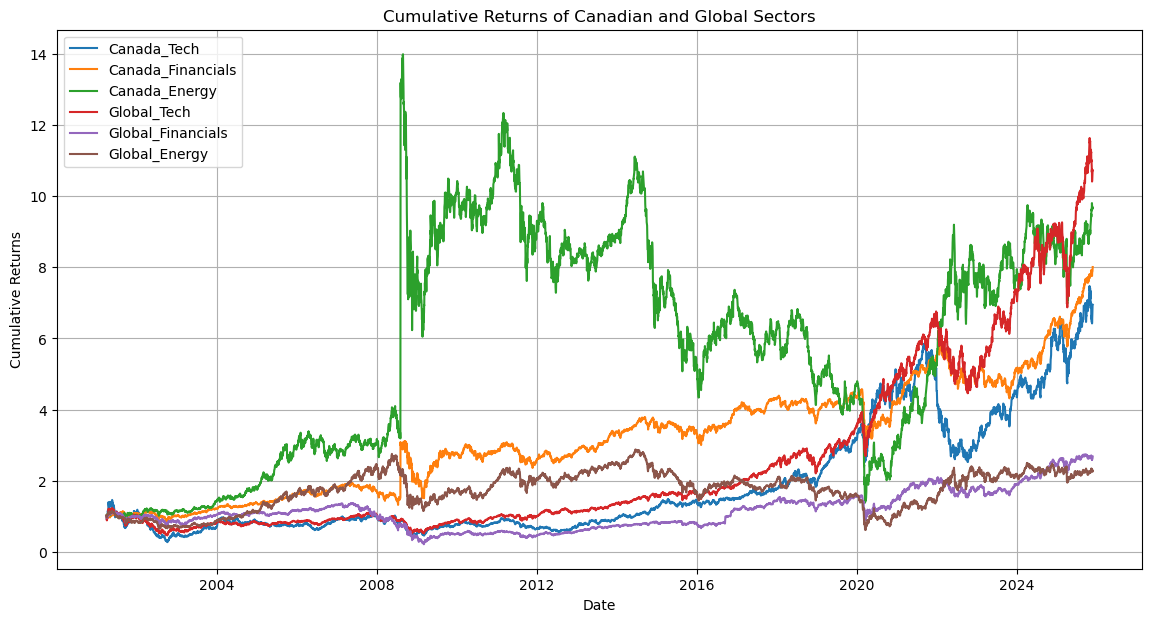

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'combined_clean' is your DataFrame and the 'Date' column is the index.
# If the 'Date' column is not the index, uncomment the following line:
# combined_clean['Date'] = pd.to_datetime(combined_clean['Date'])
# combined_clean.set_index('Date', inplace=True)

# Display the first few rows to confirm
print(combined_clean.head())

### **Question 1: Performance Comparison (Canadian vs. Global Sectors)**



#### **Cumulative Retu
# Calculate daily returns
daily_returns = combined_clean.pct_change()

# Calculate cumulative returns
cumulative_returns = (1 + daily_returns).cumprod()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)
plt.title('Cumulative Returns of Canadian and Global Sectors')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Calculate CAGR
days = (cumulative_returns.index[-1] - cumulative_returns.index[0]).days
cagr = (cumulative_returns.iloc[-1]) ** (365.0 / days) - 1

print("Compound Annual Growth Rate (CAGR):")
print(cagr)

Compound Annual Growth Rate (CAGR):
Canada_Tech          0.081726
Canada_Financials    0.087959
Canada_Energy        0.096313
Global_Tech          0.100930
Global_Financials    0.040783
Global_Energy        0.034076
Name: 2025-11-26 05:00:00+00:00, dtype: float64


In [21]:
# Calculate the annualized standard deviation of daily returns
volatility = daily_returns.std() * np.sqrt(252) # 252 trading days in a year

print("\nAnnualized Volatility (Standard Deviation):")
print(volatility)


Annualized Volatility (Standard Deviation):
Canada_Tech          0.279435
Canada_Financials    0.267683
Canada_Energy        0.686801
Global_Tech          0.240725
Global_Financials    0.284694
Global_Energy        0.287731
dtype: float64


In [23]:
# Calculate Beta for each Canadian sector against its Global counterpart
beta_tech = (daily_returns['Canada_Tech'].cov(daily_returns['Global_Tech'])) / daily_returns['Global_Tech'].var()
beta_financials = (daily_returns['Canada_Financials'].cov(daily_returns['Global_Financials'])) / daily_returns['Global_Financials'].var()
beta_energy = (daily_returns['Canada_Energy'].cov(daily_returns['Global_Energy'])) / daily_returns['Global_Energy'].var()

print("\nBeta:")
print(f"Canada_Tech vs Global_Tech: {beta_tech:.4f}")
print(f"Canada_Financials vs Global_Financials: {beta_financials:.4f}")
print(f"Canada_Energy vs Global_Energy: {beta_energy:.4f}")


Beta:
Canada_Tech vs Global_Tech: 0.7554
Canada_Financials vs Global_Financials: 0.4445
Canada_Energy vs Global_Energy: 0.8810


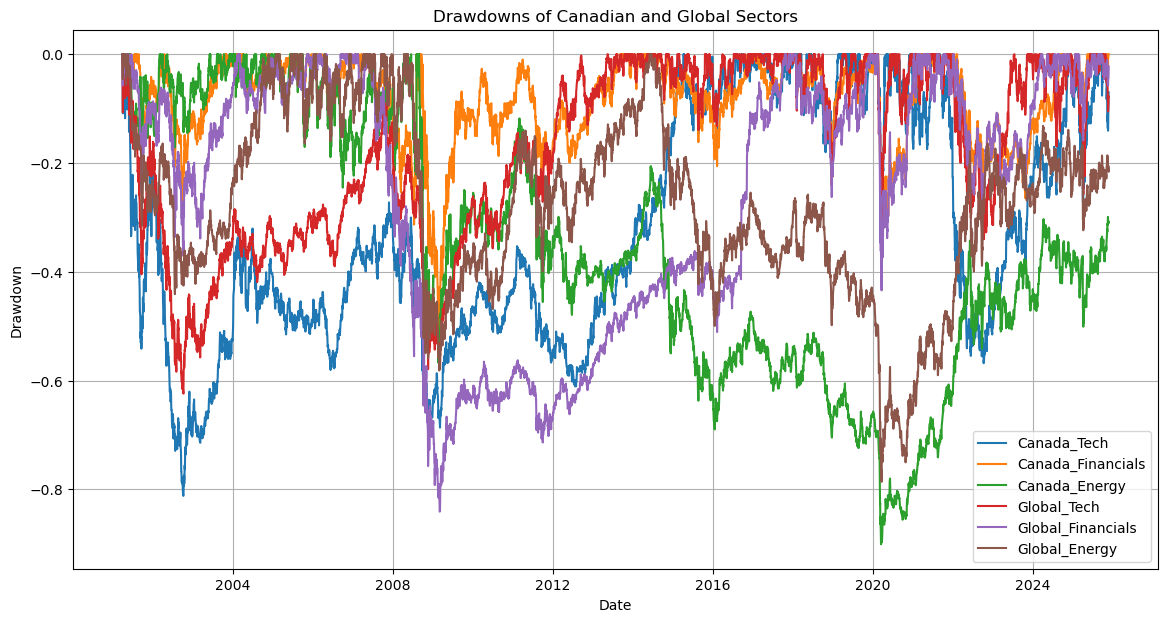


Maximum Drawdowns:
Canada_Tech         -0.812080
Canada_Financials   -0.514932
Canada_Energy       -0.900956
Global_Tech         -0.624026
Global_Financials   -0.841055
Global_Energy       -0.786224
dtype: float64


In [25]:
# Calculate drawdowns
def calculate_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    peak = cumulative.expanding(min_periods=1).max()
    drawdown = (cumulative - peak) / peak
    return drawdown

drawdowns = combined_clean.pct_change().apply(calculate_drawdown)

# Plot drawdowns
plt.figure(figsize=(14, 7))
for column in drawdowns.columns:
    plt.plot(drawdowns.index, drawdowns[column], label=column)
plt.title('Drawdowns of Canadian and Global Sectors')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

# Print max drawdowns
print("\nMaximum Drawdowns:")
print(drawdowns.min())

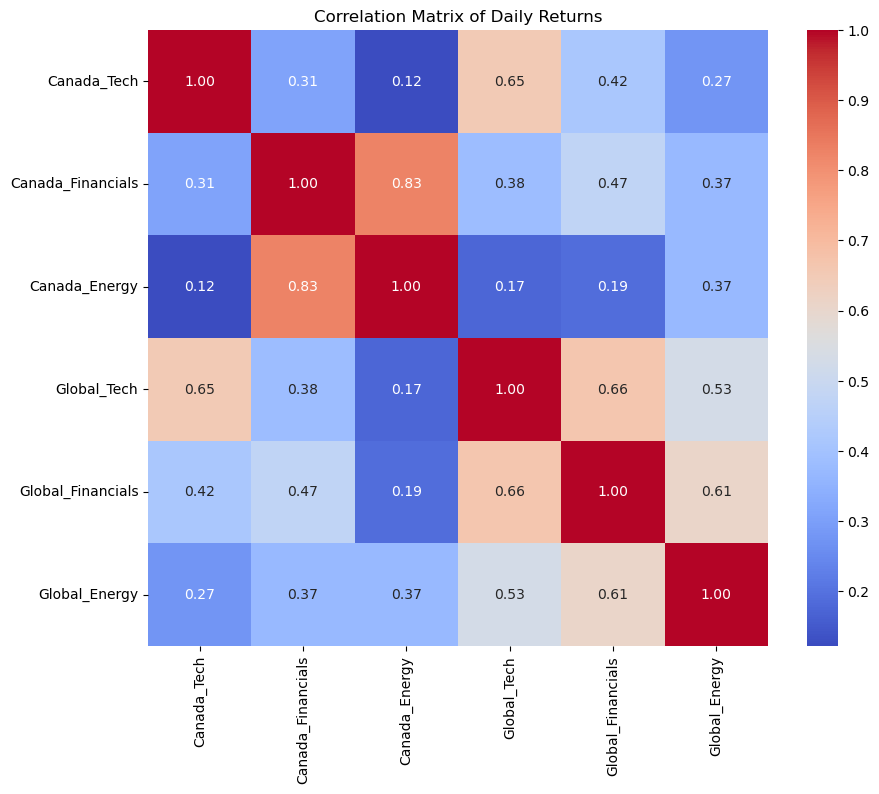


Correlation Matrix:
                   Canada_Tech  Canada_Financials  Canada_Energy  Global_Tech  \
Canada_Tech           1.000000           0.310630       0.122064     0.650720   
Canada_Financials     0.310630           1.000000       0.827064     0.380140   
Canada_Energy         0.122064           0.827064       1.000000     0.174530   
Global_Tech           0.650720           0.380140       0.174530     1.000000   
Global_Financials     0.415422           0.472760       0.189504     0.664278   
Global_Energy         0.273061           0.370742       0.369095     0.527369   

                   Global_Financials  Global_Energy  
Canada_Tech                 0.415422       0.273061  
Canada_Financials           0.472760       0.370742  
Canada_Energy               0.189504       0.369095  
Global_Tech                 0.664278       0.527369  
Global_Financials           1.000000       0.607323  
Global_Energy               0.607323       1.000000  


In [27]:
# Calculate the correlation matrix of daily returns
correlation_matrix = daily_returns.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Daily Returns')
plt.show()

print("\nCorrelation Matrix:")
print(correlation_matrix)

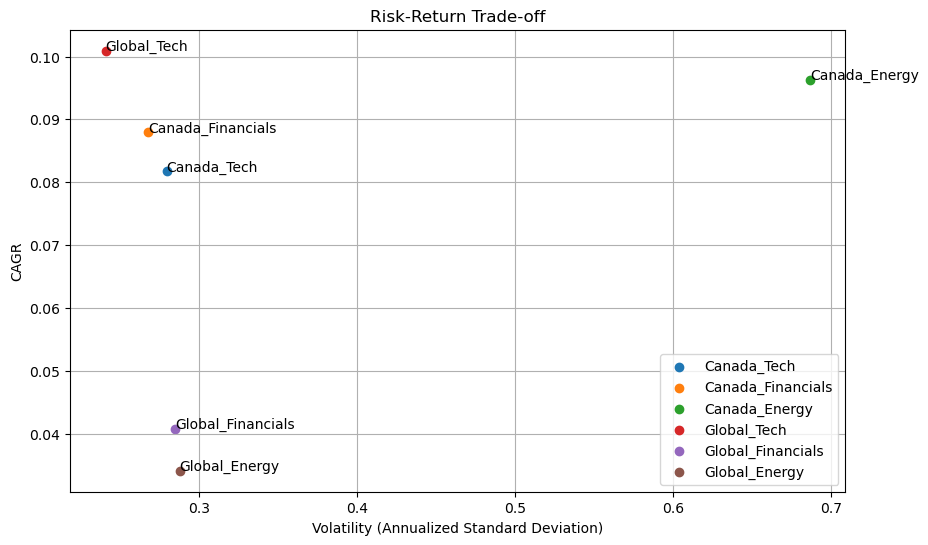

In [29]:
# Create a DataFrame for summary statistics
summary_stats = pd.DataFrame({
    'CAGR': cagr,
    'Volatility': volatility
})

plt.figure(figsize=(10, 6))
for i, sector in enumerate(summary_stats.index):
    x = summary_stats.loc[sector, 'Volatility']
    y = summary_stats.loc[sector, 'CAGR']
    plt.scatter(x, y, label=sector)
    plt.text(x, y, sector)

plt.title('Risk-Return Trade-off')
plt.xlabel('Volatility (Annualized Standard Deviation)')
plt.ylabel('CAGR')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Consolidate all the calculated metrics into a single DataFrame
summary_df = pd.DataFrame({
    'CAGR': cagr,
    'Volatility': volatility,
    'Max Drawdown': drawdowns.min()
})

# Add Beta values
summary_df['Beta'] = np.nan
summary_df.loc['Canada_Tech', 'Beta'] = beta_tech
summary_df.loc['Canada_Financials', 'Beta'] = beta_financials
summary_df.loc['Canada_Energy', 'Beta'] = beta_energy


print("\nSummary of Key Metrics:")
print(summary_df)


Summary of Key Metrics:
                       CAGR  Volatility  Max Drawdown      Beta
Canada_Tech        0.081726    0.279435     -0.812080  0.755361
Canada_Financials  0.087959    0.267683     -0.514932  0.444511
Canada_Energy      0.096313    0.686801     -0.900956  0.881014
Global_Tech        0.100930    0.240725     -0.624026       NaN
Global_Financials  0.040783    0.284694     -0.841055       NaN
Global_Energy      0.034076    0.287731     -0.786224       NaN


In [47]:
# Forecasting next 10 days for all ETFs using Prophet (Timezone FIXED)

import os
import pandas as pd
import numpy as np

try:
    from prophet import Prophet
except:
    from fbprophet import Prophet

FORECAST_DAYS = 10
OUTPUT_DIR = "prophet_forecasts"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load your cleaned data if not already available
try:
    combined_clean
except NameError:
    combined_clean = pd.read_csv("adj_close_prices.csv", index_col=0, parse_dates=True)

# Ensure datetime index & remove timezone
combined_clean.index = pd.to_datetime(combined_clean.index).tz_localize(None)

combined_clean = combined_clean.sort_index()

all_forecasts = []

for ticker in combined_clean.columns:

    df = combined_clean[[ticker]].dropna().reset_index()
    df.columns = ["ds", "y"]

    # 🔥 Remove timezone here too (double safety)
    df["ds"] = pd.to_datetime(df["ds"]).dt.tz_localize(None)

    if df.shape[0] < 30:
        print(f"Skipping {ticker} — not enough data.")
        continue

    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.05,
        seasonality_mode="multiplicative"
    )

    model.fit(df)

    future = model.make_future_dataframe(periods=FORECAST_DAYS)
    future["ds"] = future["ds"].dt.tz_localize(None)   # 🔥 Prophet-safe

    forecast = model.predict(future)

    forecast["is_forecast"] = ~forecast["ds"].isin(df["ds"])

    tidy = forecast[["ds", "yhat", "yhat_lower", "yhat_upper", "is_forecast"]].copy()
    tidy.columns = ["Date", "Predicted_Price", "Predicted_Lower", "Predicted_Upper", "is_forecast"]

    tidy["Predicted_Return"] = tidy["Predicted_Price"].pct_change()
    tidy["Ticker"] = ticker

    out_file = os.path.join(OUTPUT_DIR, f"forecast_{ticker.replace('.', '_')}.csv")
    tidy.to_csv(out_file, index=False)

    print(f"Saved forecast for {ticker}: {out_file}")

    all_forecasts.append(tidy)

# Save combined forecasts
if all_forecasts:
    final_df = pd.concat(all_forecasts, ignore_index=True)
    final_out = os.path.join(OUTPUT_DIR, "combined_forecasts_all_etfs.csv")
    final_df.to_csv(final_out, index=False)
    print(f"Saved combined forecast: {final_out}")
else:
    print("No forecasts generated.")


13:22:28 - cmdstanpy - INFO - Chain [1] start processing
13:22:37 - cmdstanpy - INFO - Chain [1] done processing


Saved forecast for Canada_Tech: prophet_forecasts\forecast_Canada_Tech.csv


13:22:38 - cmdstanpy - INFO - Chain [1] start processing
13:22:44 - cmdstanpy - INFO - Chain [1] done processing


Saved forecast for Canada_Financials: prophet_forecasts\forecast_Canada_Financials.csv


13:22:46 - cmdstanpy - INFO - Chain [1] start processing
13:22:58 - cmdstanpy - INFO - Chain [1] done processing


Saved forecast for Canada_Energy: prophet_forecasts\forecast_Canada_Energy.csv


13:23:00 - cmdstanpy - INFO - Chain [1] start processing
13:23:07 - cmdstanpy - INFO - Chain [1] done processing


Saved forecast for Global_Tech: prophet_forecasts\forecast_Global_Tech.csv


13:23:09 - cmdstanpy - INFO - Chain [1] start processing
13:23:21 - cmdstanpy - INFO - Chain [1] done processing


Saved forecast for Global_Financials: prophet_forecasts\forecast_Global_Financials.csv


13:23:23 - cmdstanpy - INFO - Chain [1] start processing
13:23:41 - cmdstanpy - INFO - Chain [1] done processing


Saved forecast for Global_Energy: prophet_forecasts\forecast_Global_Energy.csv
Saved combined forecast: prophet_forecasts\combined_forecasts_all_etfs.csv
